In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import pprint
import time
import ctypes
import logging


import numpy as np
import nidaqmx
import nidaqmx._lib  # Due to NIDAQmx C-API bug needed to bypass property getter (according to qudi)
import nidaqmx.stream_readers
import matplotlib.pyplot as plt

import qcsapphire
import qt3rfsynthcontrol

pp = pprint.PrettyPrinter(indent=4)
logging.basicConfig(level = logging.INFO)

In [4]:
nidaq_device_name = 'Dev1'

In [5]:
nisys = nidaqmx.system.System()
device = nidaqmx.system.Device(nidaq_device_name)

In [6]:
device.reset_device()

In [7]:
qcsapphire.discover_devices()

[['COM3',
  'Intel(R) Active Management Technology - SOL (COM3)',
  'PCI\\VEN_8086&DEV_43E3&SUBSYS_0A541028&REV_11\\3&11583659&1&B3'],
 ['COM5',
  'USB Serial Device (COM5)',
  'USB VID:PID=0483:A3E5 SER=206A36705430 LOCATION=1-9:x.0'],
 ['COM7',
  'USB Serial Device (COM7)',
  'USB VID:PID=239A:8014 SER=3B0D07C25831555020312E341A3214FF LOCATION=1-10:x.0'],
 ['COM10',
  'USB Serial Device (COM10)',
  'USB VID:PID=04D8:000A SER= LOCATION=1-2:x.0']]

In [8]:
rfsynth = qt3rfsynthcontrol.QT3SynthHD('COM5')
pulser = qcsapphire.Pulser('COM10')

In [9]:
rfsynth.rf_off(0)
rfsynth.rf_off(1)
pulser.set_all_state_off()

In [197]:
pulser._readlines()

[]

In [10]:
#uncomment to see current state of RF synth and QCS pulser
pp.pprint(rfsynth.hw_info())
#pp.pprint(rfsynth.current_status())

print('global settings')
pp.pprint(pulser.report_global_settings())

for channel in range(1,5):
    pp.pprint(f'channel {channel}')
    pp.pprint(pulser.report_channel_settings(channel))

[   ('model_type', 'WFT SynthHD 1694'),
    ('serial_number', 1694),
    ('fw_version', 'Firmware Version 3.23'),
    ('hw_version', 'Hardware Version 2.06'),
    ('sub_version', 'HD')]
global settings
[   (':PULSE0:STATE?', '0'),
    (':PULSE0:PERIOD?', '0.000100000'),
    (':PULSE0:MODE?', 'SING'),
    (':PULSE0:BCOUNTER?', '5'),
    (':PULSE0:PCOUNTER?', '3'),
    (':PULSE0:OCOUNTER?', '2'),
    (':PULSE0:EXTERNAL:MODE?', 'TRIG'),
    (':PULSE0:EXTERNAL:LEVEL?', '2.50'),
    (':PULSE0:EXTERNAL:EDGE?', 'RIS'),
    (':PULSE0:EXTERNAL:POLARITY?', 'HIGH')]
'channel 1'
[   (':PULSE1:STATE?', '0'),
    (':PULSE1:WIDTH?', '0.000999900'),
    (':PULSE1:DELAY?', '0.00000000'),
    (':PULSE1:SYNC?', 'T0'),
    (':PULSE1:MUX?', '1'),
    (':PULSE1:POLARITY?', 'NORM'),
    (':PULSE1:OUTPUT:AMPLITUDE?', '5.00'),
    (':PULSE1:CMODE?', 'NORM'),
    (':PULSE1:BCOUNTER?', '5'),
    (':PULSE1:PCOUNTER?', '4'),
    (':PULSE1:WCOUNTER?', '0'),
    (':PULSE1:CGATE?', 'DIS')]
'channel 2'
[   (':PULSE2:S

In [11]:
#Configure the NI DAQ

def configure_tasks(post_fix_task_name = None, 
                    device_name = 'Dev1',
                    clock_counter = 'ctr1',
                    clock_di_line = 'port0',
                    edge_input_channel = 'PFI12',
                    edge_input_counter = 'ctr2',
                    clock_rate = 1000, 
                    N_data_samples_to_acquire = 500,
                    trigger_input = 'PFI0',
                    new_edge_task = False,
                    new_clock_task = False,
                    continuous_daq = False):
   
    #clock_task_name = f'sample_clock{post_fix_task_name}' 
    clock_task = nidaqmx.Task()

    
    if new_clock_task:
        clock_task.di_channels.add_di_chan(f'{device_name}/{clock_di_line}')
        clock_task.timing.cfg_samp_clk_timing(clock_rate,
                                    sample_mode=nidaqmx.constants.AcquisitionType.CONTINUOUS)
     
        clock_channel = f'/{device_name}/di/SampleClock'

    else:
        #this adds the clock signal to the output channel
        #is this necessary? 
        clock_task.co_channels.add_co_pulse_chan_freq(
                '/{0}/{1}'.format(device_name, clock_counter),
                freq=clock_rate,
                idle_state=nidaqmx.constants.Level.LOW)

        # clock_task.timing.cfg_implicit_timing(
        #     sample_mode=nidaqmx.constants.AcquisitionType.FINITE,
        #     samps_per_chan=n_steps+2) #qudi configures with n_steps + 1, should recheck why. suspicious extra "1" floating around (n_steps = 101)

        clock_task.timing.cfg_implicit_timing(
            sample_mode=nidaqmx.constants.AcquisitionType.CONTINUOUS,
            samps_per_chan=clock_rate) #qudi configures with n_steps + 1, should recheck why. suspicious extra "1" floating around (n_steps = 101)

        clock_channel = '/{0}InternalOutput'.format(clock_task.channel_names[0])

    #edge_detector_task_name = f'edge_input{post_fix_task_name}'

    edge_detector_task = nidaqmx.Task()

    #todo -- try to replace all of this with edge_detector_task.add_ci_count_edges_chan
    

    ctr_name = f'/{device_name}/{edge_input_counter}'
    chnl_name = f'/{device_name}/{edge_input_channel}'
    
    if new_edge_task: #following nspyre recipe
        edge_detector_task.ci_channels.add_ci_count_edges_chan(
                                    ctr_name,
                                    edge=nidaqmx.constants.Edge.RISING,
                                    initial_count=0,
                                    count_direction=nidaqmx.constants.CountDirection.COUNT_UP)
        edge_detector_task.ci_channels.all.ci_count_edges_term = chnl_name
        
        if continuous_daq:
            edge_detector_task.timing.cfg_samp_clk_timing(clock_rate, 
                                                          source=clock_channel,
                                                          active_edge=nidaqmx.constants.Edge.RISING, 
                                                          sample_mode=nidaqmx.constants.AcquisitionType.CONTINUOUS)    
        else:        
            edge_detector_task.timing.cfg_samp_clk_timing(clock_rate, 
                                                          source=clock_channel,
                                                          active_edge=nidaqmx.constants.Edge.RISING, 
                                                          sample_mode=nidaqmx.constants.AcquisitionType.FINITE,
                                                          samps_per_chan=N_data_samples_to_acquire)
        
    else:
        # why does qudi count the period of signal? In units of "ticks" -- is that the same as edge counting? 
        
        edge_detector_task.ci_channels.add_ci_period_chan(
                            ctr_name,
                            min_val=0,
                            max_val=100000000,
                            units=nidaqmx.constants.TimeUnits.TICKS,
                            edge=nidaqmx.constants.Edge.RISING)
        # I get no data when I swap out the line above for this line
        # edge_detector_task.ci_channels.add_ci_count_edges_chan(
        #                             ctr_name,
        #                             edge=nidaqmx.constants.Edge.RISING,
        #                             initial_count=0,
        #                             count_direction=nidaqmx.constants.CountDirection.COUNT_UP)
        
        # from qudi -- apparently this overcomes some kind of bug in the C-library, according to comments in qudi code
        try:
            # this sets the counter to read from the appropriate terminal
            nidaqmx._lib.lib_importer.windll.DAQmxSetCIPeriodTerm(
                edge_detector_task._handle,
                ctypes.c_char_p(ctr_name.encode('ascii')),
                ctypes.c_char_p(clock_channel.encode('ascii')))
            
            #this tells the counter which clock to use
            nidaqmx._lib.lib_importer.windll.DAQmxSetCICtrTimebaseSrc(
                edge_detector_task._handle,
                ctypes.c_char_p(ctr_name.encode('ascii')),
                ctypes.c_char_p(chnl_name.encode('ascii')))
        except:
            nidaqmx._lib.lib_importer.cdll.DAQmxSetCIPeriodTerm(
                edge_detector_task._handle,
                ctypes.c_char_p(ctr_name.encode('ascii')),
                ctypes.c_char_p(clock_channel.encode('ascii')))
            nidaqmx._lib.lib_importer.cdll.DAQmxSetCICtrTimebaseSrc(
                edge_detector_task._handle,
                ctypes.c_char_p(ctr_name.encode('ascii')),
                ctypes.c_char_p(chnl_name.encode('ascii')))

        
        if continuous_daq:
            edge_detector_task.timing.cfg_implicit_timing(sample_mode=nidaqmx.constants.AcquisitionType.CONTINUOUS)
        else:
            edge_detector_task.timing.cfg_implicit_timing(sample_mode=nidaqmx.constants.AcquisitionType.FINITE,
                                                      samps_per_chan=N_data_samples_to_acquire)
    
    if trigger_input:
        ## maybe we should turn this into a gate and then we can start the task to run for a large number of cycles instead
        # of having a sofware for-loop below
        edge_detector_task.triggers.arm_start_trigger.trig_type =  nidaqmx.constants.TriggerType.DIGITAL_EDGE
        edge_detector_task.triggers.arm_start_trigger.dig_edge_edge =  nidaqmx.constants.Edge.RISING
        edge_detector_task.triggers.arm_start_trigger.dig_edge_src = f'/{device_name}/{trigger_input}'
    

    edge_detector_reader = nidaqmx.stream_readers.CounterReader(edge_detector_task.in_stream)
    
    return clock_task, edge_detector_task, edge_detector_reader



In [59]:
def setup_t1_pulser(pulser, period, t_laser, t_delay, laser_channel = 'A', readout_timer_channel = 'B'):

    pulser.system.period(period) 

    pulser.channel(laser_channel).cmode('normal')
    pulser.channel(laser_channel).polarity('normal')
    pulser.channel(laser_channel).delay(0)
    pulser.channel(laser_channel).width(t_laser)

    readout_start = t_laser + t_delay

    pulser.channel(readout_timer_channel).cmode('normal')
    pulser.channel(readout_timer_channel).polarity('normal')
    pulser.channel(readout_timer_channel).delay(readout_start) 
    pulser.channel(readout_timer_channel).width(t_laser)

    pulser.channel(laser_channel).output.amplitude(5.0)
    pulser.multiplex([laser_channel, readout_timer_channel], laser_channel)

    



In [60]:
setup_t1_pulser(pulser, 15e-3, 5e-6, 0.5e-3)

In [17]:

channel_names = np.array(pulser.channel_names()[1:])
m = len(channel_names)
for chan in channel_names:
    if pulser.channel(str(chan)).state() == '1':
        mux_output = int(pulser.channel(str(chan)).mux())
        idx = np.array(list(np.binary_repr(mux_output).zfill(m))).astype(np.int8)[::-1]
        output_channels = channel_names[np.where(idx == 1)]
        print(f'channel {chan} output from timers --> {",".join(output_channels)}')


channel A output from timers --> A,B


In [229]:
#turn everything on
for i in range(5):
    pulser.channel(i).state(1)
    

In [43]:
#pulser.channel('D').mux(1 + 4) #output from D will be all three trigger signals
#pulser.channel('D').mux(2)
pulser.multiplex(['A', 'B'], 'D')
pulser.channel('D').output.amplitude(3.3)
pulser.channel('D').width(pulser.system.period())

'ok'

In [44]:
pulser.system.state(1)
pulser.channel('D').state(1)
pulser.channel('A').state(1)
pulser.channel('B').state(1)


'ok'

In [61]:
pulser.report_global_settings()

[(':PULSE0:STATE?', '1'),
 (':PULSE0:PERIOD?', '0.015000000'),
 (':PULSE0:MODE?', 'SING'),
 (':PULSE0:BCOUNTER?', '5'),
 (':PULSE0:PCOUNTER?', '3'),
 (':PULSE0:OCOUNTER?', '2'),
 (':PULSE0:EXTERNAL:MODE?', 'TRIG'),
 (':PULSE0:EXTERNAL:LEVEL?', '2.50'),
 (':PULSE0:EXTERNAL:EDGE?', 'RIS'),
 (':PULSE0:EXTERNAL:POLARITY?', 'HIGH')]

In [62]:
for i in range(1,5):
    print(i)
    print(pulser.report_channel_settings(i))

1
[(':PULSE1:STATE?', '1'), (':PULSE1:WIDTH?', '0.000005000'), (':PULSE1:DELAY?', '0.00000000'), (':PULSE1:SYNC?', 'T0'), (':PULSE1:MUX?', '3'), (':PULSE1:POLARITY?', 'NORM'), (':PULSE1:OUTPUT:AMPLITUDE?', '5.00'), (':PULSE1:CMODE?', 'NORM'), (':PULSE1:BCOUNTER?', '5'), (':PULSE1:PCOUNTER?', '4'), (':PULSE1:WCOUNTER?', '0'), (':PULSE1:CGATE?', 'DIS')]
2
[(':PULSE2:STATE?', '1'), (':PULSE2:WIDTH?', '0.000005000'), (':PULSE2:DELAY?', '0.00050500'), (':PULSE2:SYNC?', 'T0'), (':PULSE2:MUX?', '1'), (':PULSE2:POLARITY?', 'NORM'), (':PULSE2:OUTPUT:AMPLITUDE?', '5.00'), (':PULSE2:CMODE?', 'NORM'), (':PULSE2:BCOUNTER?', '5'), (':PULSE2:PCOUNTER?', '4'), (':PULSE2:WCOUNTER?', '0'), (':PULSE2:CGATE?', 'DIS')]
3
[(':PULSE3:STATE?', '0'), (':PULSE3:WIDTH?', '0.000001000'), (':PULSE3:DELAY?', '0.00000000'), (':PULSE3:SYNC?', 'T0'), (':PULSE3:MUX?', '4'), (':PULSE3:POLARITY?', 'NORM'), (':PULSE3:OUTPUT:AMPLITUDE?', '5.00'), (':PULSE3:CMODE?', 'NORM'), (':PULSE3:BCOUNTER?', '5'), (':PULSE3:PCOUNTER?',

In [222]:
rfsynth.rf_on(0)

In [223]:
period

0.0001

In [165]:
#after checking output signals with scope above, can put pulser into software trigger mode


In [50]:
pulser.system.mode('single')
pulser.system.external.mode('trigger')
pulser.system.state(1)



'ok'

In [51]:
# test scope for software trigger working

In [56]:
float(pulser.system.period())

0.015

In [63]:
for i in range(1000):
    pulser.software_trigger()
    time.sleep(1.1*float(pulser.system.period()))

In [235]:
def run_once(detector_task, detector_reader, clock_rate,  N_samples,  read_write_timeout=10, pulser = None):
    
    detector_task.wait_until_done() #this doesn't seem to always work... so add delay below
    detector_task.start()
    data_buffer = np.zeros(N_samples)
    
    if pulser:
        pulser.software_trigger()
    
    time.sleep(1.1*float(pulser.system.period())) #need to wait for full sets of triggers
    read_samples = detector_reader.read_many_sample_double(
                            data_buffer,
                            number_of_samples_per_channel=N_samples,
                            timeout=read_write_timeout)
    detector_task.stop()
    try:
        assert read_samples == N_samples
    except Exception as e:
        print(e)
        print(f'{read_samples} != {N_samples}')
        raise e
        
    return data_buffer

In [225]:
def run_with_options(freq_low, freq_high, freq_step,
                     N_samples_per_step, clock_rate, daq_time,
                     trigger_input, pulser, rfsynth, 
                     use_new_edge_task, new_clock_task, 
                     continuous_daq, rf_power,
                     cooling_time = 0, N_scans_per_step =  100):


    data = None

    clock_task, edge_detector_task, edge_detector_reader = configure_tasks(post_fix_task_name = 'v10', 
                                                                            clock_rate = clock_rate, 
                                                                            N_data_samples_to_acquire = N_samples_per_step,
                                                                            edge_input_channel = 'PFI12',
                                                                            clock_counter = 'ctr1',
                                                                            trigger_input = trigger_input,
                                                                            new_edge_task = use_new_edge_task,
                                                                            new_clock_task = new_clock_task,
                                                                            continuous_daq = continuous_daq)

    try:
        

        if clock_task:
            clock_task.start()

        raw_data = {}
        
        current_freq = freq_low
        step = 0

        # if rfsynth:
        #     rfsynth.rf_off(0)
        
     
        while current_freq < freq_high:
                
            if rfsynth:
                rfsynth.set_channel_fixed_output(0, rf_power, current_freq)
                time.sleep(0.001) #wait 1 ms

#             if normalize:
#                 # if we really wanted to do a "normalized" approach (which, in CWODMR is done in order to prevent the sample from heating
#                 #we would need to use a different pulser sequence that doesn't include the RF gate
#                 pulser.channel('B').state(0) #how long does this take? ~115kHz baud rate to pulser. This is slow. 10 microseconds per bit. ~10+ bits per message. plus the time it takes for the pulser to respond
                
#                 normalized_count_rate_pre = run_once(edge_detector_task, edge_detector_reader, clock_rate, N_samples_per_step, read_write_timeout = 10, pulser = pulser)
#                 #time.sleep(1.1*(period - readout_pulse_start + width_readout_laser)) #wait for pulser to finish 

            data_at_one_freq = []
            for i in range(N_scans_per_step):
                _data = run_once(edge_detector_task, edge_detector_reader, clock_rate, N_samples_per_step, read_write_timeout = 10, pulser = pulser)
                data_at_one_freq.append(_data)
            #time.sleep(1.1*(period - readout_pulse_start + width_readout_laser)) #wait for pulser to finish 


            # if normalize:
            #     normalized_count_rate_post = run_once(edge_detector_task, edge_detector_reader, clock_rate, N_samples_per_step, read_write_timeout = 10, pulser = pulser)
            #     #time.sleep(1.1*(period - readout_pulse_start + width_readout_laser)) #wait for pulser to finish 

            #print(f'collected {len(data_at_one_freq)} measures at this frequency')
            #print(data_at_one_freq)

            #current_freq_data = {}
#             if False:
#                 current_freq_data['pre'] = normalized_count_rate_pre.sum()
#                 current_freq_data['post'] = normalized_count_rate_post.sum()
                
#                 normalized_count_rate = np.mean([normalized_count_rate_pre,normalized_count_rate_post])
#                 compiled_data[current_freq] = data_at_one_freq.mean() / normalized_count_rate
#             else:
#                 compiled_data[current_freq] = data_at_one_freq.mean() * clock_rate
                
            #current_freq_data['rf'] = data_at_one_freq.sum()
            raw_data[current_freq] =  np.sum(data_at_one_freq)            
            if step % 10 == 0:
                print(f'{current_freq/1e9} GHz: {raw_data[current_freq]} counts')
                
            current_freq += freq_step
            step += 1
            
            if cooling_time > 0:
                time.sleep(cooling_time)
            
    except Exception as e:
        print(e)
        raise(e)

    finally:


        try:
            if clock_task:
                clock_task.stop()
        except Exception as e:
            print(e)

        try:
            if clock_task:
                clock_task.close()
        except Exception as e:
            print(e)

        try:
            if edge_detector_task:
                edge_detector_task.close()
        except Exception as e:
            print(e)
            
        return raw_data

In [236]:
freq_low = 2850e6
freq_high = 2900e6
freq_step = 1e6
trigger_input = 'PFI0'

use_new_edge_task = False
new_clock_task = False
continuous_daq = False
normalize = False
rf_power = -5

daq_time= width_readout_laser + aom_delay #we add the aom delay 
clock_rate = int(10e6) #10 MHz
N_daq_samples = int(daq_time * clock_rate)

#make sure we are in trigger mode
    
pulser.system.mode('single')
pulser.system.external.mode('trigger')

#turn everything on (seems that when changing system mode, state is turned to off)
for i in range(5):
    pulser.channel(i).state(1)
    
pp.pprint(pulser.report_global_settings())

for channel in range(1,5):
    pp.pprint(f'channel {channel}')
    pp.pprint(pulser.report_channel_settings(channel))
    
if rfsynth:
        rfsynth.rf_on(0)
        time.sleep(0.030)#wait 20 ms for rf to fully power up.
        

data = run_with_options(freq_low, freq_high, freq_step,  N_daq_samples, clock_rate, daq_time,
                                   trigger_input, pulser, rfsynth, use_new_edge_task, 
                                   new_clock_task, continuous_daq, normalize, rf_power, N_scans_per_step = 100)


#turn everything off
for i in range(5):
    pulser.channel(i).state(0)
    


[   (':PULSE0:STATE?', '1'),
    (':PULSE0:PERIOD?', '0.000100000'),
    (':PULSE0:MODE?', 'SING'),
    (':PULSE0:BCOUNTER?', '5'),
    (':PULSE0:PCOUNTER?', '3'),
    (':PULSE0:OCOUNTER?', '2'),
    (':PULSE0:EXTERNAL:MODE?', 'TRIG'),
    (':PULSE0:EXTERNAL:LEVEL?', '2.50'),
    (':PULSE0:EXTERNAL:EDGE?', 'RIS'),
    (':PULSE0:EXTERNAL:POLARITY?', 'HIGH')]
'channel 1'
[   (':PULSE1:STATE?', '1'),
    (':PULSE1:WIDTH?', '0.000025000'),
    (':PULSE1:DELAY?', '0.00000000'),
    (':PULSE1:SYNC?', 'T0'),
    (':PULSE1:MUX?', '5'),
    (':PULSE1:POLARITY?', 'NORM'),
    (':PULSE1:OUTPUT:AMPLITUDE?', '5.00'),
    (':PULSE1:CMODE?', 'NORM'),
    (':PULSE1:BCOUNTER?', '5'),
    (':PULSE1:PCOUNTER?', '4'),
    (':PULSE1:WCOUNTER?', '0'),
    (':PULSE1:CGATE?', 'DIS')]
'channel 2'
[   (':PULSE2:STATE?', '1'),
    (':PULSE2:WIDTH?', '0.000025000'),
    (':PULSE2:DELAY?', '0.00002700'),
    (':PULSE2:SYNC?', 'T0'),
    (':PULSE2:MUX?', '2'),
    (':PULSE2:POLARITY?', 'NORM'),
    (':PULSE2:OUTPUT

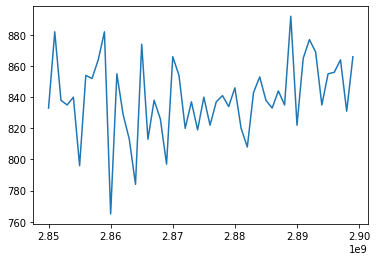

In [237]:
plt.plot(data.keys(), data.values())

In [104]:
frequencies = list(raw_data_set[0].keys())
rf_signal = {f:np.sum([scan[f]['rf'] for scan in raw_data_set]) for f in frequencies}
    
if normalize:

    background = {f:(np.sum([scan[f]['pre'] for scan in raw_data_set]) + np.sum([scan[f]['post'] for scan in raw_data_set]))/2.0 for f in frequencies}
    rf_signal = {f:rf_signal[f]/background[f] for f in frequencies}